# Object Detection

Will be implementing the **R-CNN** model from scratch. Let us first go over the basics of this model.

![R-CNN](https://production-media.paperswithcode.com/methods/new_splash-method_NaA95zW.jpg)

An R-CNN object detector will first extract object proposals from an image. Thse proposals are then warped to a specific size and passed to a neural network for feature extraction. These features will be eventually classificed into certain categories using a SVM.

---

In this assignment, we will use the **Selective Search** algorithm in order to extract region proposals from an image. To learn more about this algorithm, you can checkout [this](https://pyimagesearch.com/2020/06/29/opencv-selective-search-for-object-detection/) useful article. In addition, rather than using the SVM algorithm, we will focus on a single class and simply attach a prediction head to the feature extractor that predicts whether the region contains an object or not.



## Setup

In [1]:
import os
import itertools 

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds 

In [5]:
from tqdm.auto import tqdm

In [6]:
import cv2

## R-CNN

Implementing an R-CNN object detector is a somewhat complex multistep process. We will break it down into the following steps:

![](https://929687.smushcdn.com/2633864/wp-content/uploads/2020/07/training_simple_rcnn_pipeline_steps.png?lossy=1&strip=1&webp=1)

### Training

We have to first train the classifier before we can use it for inference.

#### Step 1: Building the Dataset

For this assignment, we recommand the PASCAL Visual Object Classes 2007 dataset. You can, however, use any other object detection datasets. We can extract the regions associated with objects of a certain class, e.g., `Car`, to then train our classifier. We can begin by downloading this dataset:

In [7]:
dataset_name = 'voc/2007' 

In [8]:
train_set = ds = tfds.load(dataset_name, split='train', shuffle_files=True)
validation_set = ds = tfds.load(dataset_name, split='validation')
test_set = ds = tfds.load(dataset_name, split='test')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/voc/2007/4.0.0.incomplete6R4PXB/voc-test.tfrecord*...:   0%|          | 0/…

Generating train examples...:   0%|          | 0/2501 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/4.0.0.incomplete6R4PXB/voc-train.tfrecord*...:   0%|          | 0…

Generating validation examples...:   0%|          | 0/2510 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/4.0.0.incomplete6R4PXB/voc-validation.tfrecord*...:   0%|        …

Dataset voc downloaded and prepared to /root/tensorflow_datasets/voc/2007/4.0.0. Subsequent calls will reuse this data.


The documentation states that each sample includes the following attributes:

```python
FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'image/filename': Text(shape=(), dtype=string),
    'labels': Sequence(ClassLabel(shape=(), dtype=int64, num_classes=20)),
    'labels_no_difficult': Sequence(ClassLabel(shape=(), dtype=int64, num_classes=20)),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=float32),
        'is_difficult': bool,
        'is_truncated': bool,
        'label': ClassLabel(shape=(), dtype=int64, num_classes=20),
        'pose': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
})
```

Note that in TensorFlow, the convention for a `BBoxFeature` attribute is to format them as `ymin, xmin, ymax, xmax`. However, the `xmin, ymin, xmax, ymax` is often preferred over the former. We will follow the second approach.

We have to iterate over the images and run the selective search algorithm to find the regions that potentially contain an object. We can use the OpenCV implementation which can be initialized using ` cv2.ximgproc.segmentation.createSelectiveSearchSegmentation`. We can implement a function to return these regions in the conventional format:

In [9]:
def selective_search(image):
    """
    Runs the Selective Search algorithm on the image and returns the potential regions.

    Parameters
    ----------
    image: ndarray
        Numpy array containing the BGR pixel values with the shape `(H, W, 3)`.

    Returns
    -------
    rectangles: list
        Potential regions in the image, formatted as `xmin`, `ymin`, `xmax`, `ymax`.
    """

    ######################
    # Your code goes here.
    rectangles = []
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    boxes = ss.process()

    # rectangle 
    for x, y, w, h in boxes:
      rectangles.append([x,y,w+x,h+y])
    ######################

    return rectangles

Note that selective search often returns more than a thousand regions for a single image. These are not all useful. By visually inspecting our dataset, we can realize that our objects are often quite large compared to the overall size of the image. Therefore, it might be better to focus on the larger proposals. To this end, let's define a function that can return the area of a region (or bouding box). This will come in handy later:

In [10]:
def area(box):
    xmin, ymin, xmax, ymax = box

    ######################
    # Your code goes here.
    w = xmax - xmin
    h = ymax - ymin
    area = float(w * h)
    ######################

    return area

The next step is to identify the **positive** and **negative** regions and save them as separate images. If a region's **IoU** with a groudtruth bounding box surpasses a certain threshold, they are known as a positive region. The original paper set this threshold at $0.7$. Negative regions on the other hand must have an IoU below a certain threshold, i.e., $0.3$. It's a good idea to only use the negative regions found in an image that contains at least one positive region. Otherwise, we might be making the job too easy for our classifier.

Let's implement a function to calculate the IoU of two boxes:

In [11]:
def compute_iou(box_a, box_b):
    xmin_a, ymin_a, xmax_a, ymax_a = box_a
    xmin_b, ymin_b, xmax_b, ymax_b = box_b

    ######################
    # Your code goes here.
    left = max(xmin_a, xmin_b)
    top = max(ymin_a, ymin_b)
    right = min(xmax_a, xmax_b)
    bottom = min(ymax_a, ymax_b)

    if (right < left) or (bottom < top):
      iou = 0
    else:
      iou_area = (right - left) * (bottom - top)
      iou_box1 = (xmax_a - xmin_a) * (ymax_a * ymin_a)
      iou_box2 = (xmax_b - xmin_b) * (ymax_b * ymin_b)

      iou = iou_area / (iou_box1 + iou_box2 - iou_area)

    ######################
    
    return iou

Another tricky case to watch out for is when a region falls entirely within a groundtruth bounding box. In this case, the IoU won't be 100%, but the region cannot be considered a negative region. Let's implement another function that can identify such a case:

In [12]:
def fully_inside(region, box):
    xmin_r, ymin_r, xmax_r, ymax_r = region
    xmin_b, ymin_b, xmax_b, ymax_b = box

    ######################
    # Your code goes here.
    if (xmin_r >= xmin_b and ymin_r >= ymin_b and xmax_r <= xmax_b and ymax_r <= ymax_b):
      result = 1
    else:
      result = 0
    ######################

    return result

We can now iterate over our data to identify and save the positive and negative regions. We will first specify our target class:

In [13]:
target_class = 6 

and our thresholds:

In [14]:
positive_thresh = 0.85
negative_thresh = 0.05

and our output directories:

In [15]:
output_dir = 'data'

and our target subsets:

In [16]:
subsets = {'train': train_set, 'valid': validation_set}

and make sure the right directories exist:

In [17]:
for subset in subsets:
    for label in ('positive', 'negative'):
        directory = os.path.join(output_dir, subset, label)
        os.makedirs(directory, exist_ok=True)

and finally, a maximum for the number of positive and negative regions we'd like to extract from a single image.

In [18]:
max_positives = 30
max_negatives = 10 

and the target size that the images will be warped to. Since we want to use the ResNet-50 as our feature extractor, $224 \times 224$ seems suitable.

In [19]:
target_size = (224, 224)

Feel free to tune any of the variables above if you think you can imporve the performance.

We're ready to start iterating over the dataset. 

Note that this step will take a while. Selective Search is quite slow (hence why we dropped in FRCCN). 

In [20]:
for subset, iterator in subsets.items():

    index = 1

    for sample in tqdm(iterator, desc=subset):

        num_positives = 0
        num_negatives = 0

        image = sample['image'].numpy()
        height, width, channels = image.shape
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        objects = sample['objects']
        labels = objects['label'].numpy()

        if target_class not in labels:
            continue

        boxes = objects['bbox'].numpy()
        boxes = [(xmin * width, ymin * height, xmax * width, ymax * height) for (ymin, xmin, ymax, xmax) in boxes]
        regions = selective_search(image)

        regions = sorted(regions, key=area)
        regions = reversed(regions)

        matched = [(region, [(box, compute_iou(box, region)) for box in boxes]) for region in regions]
        matched = [(region, *max(li, key=lambda pair: pair[1])) for region, li in matched]

        for region, box, iou in matched:
            xmin, ymin, xmax, ymax = region

            if iou > positive_thresh:
                if num_positives < max_positives:
                    crop = image[ymin:ymax, xmin:xmax, :]
                    crop = cv2.resize(crop, target_size)
                    filepath = os.path.join(output_dir, subset, 'positive', f'{index:06d}.jpg')
                    cv2.imwrite(filepath, crop)
                    num_positives += 1
                    index += 1

            if iou < negative_thresh and not fully_inside(region, box):
                if num_negatives < max_negatives:
                    crop = image[ymin:ymax, xmin:xmax, :]
                    crop = cv2.resize(crop, target_size)
                    filepath = os.path.join(output_dir, subset, 'negative', f'{index:06d}.jpg')
                    cv2.imwrite(filepath, crop)
                    num_negatives += 1
                    index += 1
            
            if num_positives == max_positives and num_negatives == max_negatives:
                break

train:   0%|          | 0/2501 [00:00<?, ?it/s]

valid:   0%|          | 0/2510 [00:00<?, ?it/s]

The total size of the extracted dataset came out to:

In [21]:
!du -sh data 

266M	data


and the number of positive and negative samples, respectively, are:

In [22]:
!ls data/train/positive -1 | wc -l
!ls data/train/negative -1 | wc -l 

1110
4020


Let's load this new dataset in order to train the classifier. 

In [23]:
batch_size = 64 

In [24]:
train_set_builder = tfds.folder_dataset.ImageFolder('data')
train_set = train_set_builder.as_dataset(split='train', batch_size=batch_size, as_supervised=True, shuffle_files=True)
validation_set_builder = tfds.folder_dataset.ImageFolder('data')
validation_set = validation_set_builder.as_dataset(split='valid', batch_size=batch_size, as_supervised=True)

Let's visualize a few samples to make sure we've got it right:

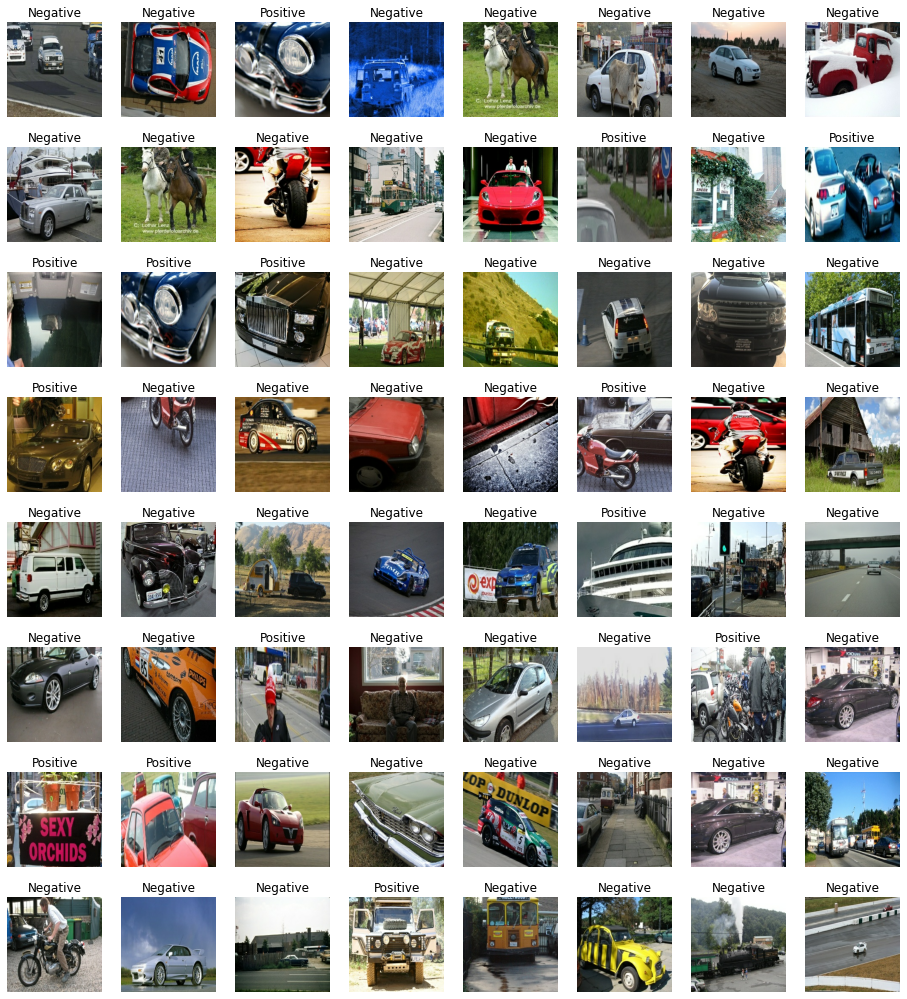

In [25]:
figure, axes = plt.subplots(8, 8, figsize=(16, 18))
for images, labels in train_set.take(1):
    for index, (image, positive) in enumerate(zip(images, labels)):
        i, j = index % 8, index // 8
        axes[i, j].imshow(image)
        axes[i, j].axis('off')
        axes[i, j].set_title('Positive' if positive else 'Negative')
plt.show()

#### Step 2: Finetuning ResNet

As previously stated, we are going to finetune a ResNet-50 model. We can load this model by using `tf.keras.applications`. 

In [26]:
resnet = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet')

94765736/94765736 [==============================] - 5s 0us/step


We have to define an input tensor to pass through `resnet`. One thing to note here is that we need to perform the same preprocessing steps that they performed when training ResNet-50. TensorFlow provides us with a function for this purpose, which we can weave into the model itself. You can read more about this function [here](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/preprocess_input).

In [27]:
input_tensor = tf.keras.Input(shape=(*target_size, 3))
############################################
feature_map = None  # Your code goes here.
input = tf.keras.applications.resnet50.preprocess_input(input_tensor)
feature_map = resnet(input)
############################################

We can then use a `GlobalAveragePooling2D` layer to transform the generated feature map to a feature vector.

In [28]:
feature_vector = tf.keras.layers.GlobalAveragePooling2D()(feature_map)

Finally, we can classify this vector using a small MLP.

In [235]:
############################################
output_tensor = None  # Your code goes here.
x = tf.keras.layers.Dense(1024, activation='relu')(feature_vector)
x = tf.keras.layers.Dense(512, activation='relu')(x)
output_tensor = tf.keras.layers.Dense(1, activation='sigmoid')(x)
############################################

We can now define our model:

In [236]:
model = tf.keras.Model(input_tensor, output_tensor)

and compile it. We recommend to use the BinaryFocalLoss to handle the class imbalance present within our data. However, feel free to use any other loss function or even optimizer, if you believe it'll improve the results.

In [237]:
optimizer = tf.keras.optimizers.SGD()
loss = tf.keras.losses.BinaryFocalCrossentropy()
metrics = [tf.keras.metrics.AUC(), tf.keras.metrics.BinaryAccuracy()]
model.compile(optimizer, loss, metrics=metrics)

We can now train the model on our extracted dataset:

In [238]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# model.fit(train_set, validation_data=validation_set, epochs=10, callbacks=[early_stop])
model.fit(train_set, validation_data=validation_set, epochs=10)

Epoch 1/10
81/81 [==============================] - 69s 792ms/step - loss: 0.0496 - auc_7: 0.9756 - binary_accuracy: 0.9292 - val_loss: 0.1226 - val_auc_7: 0.8303 - val_binary_accuracy: 0.8526
Epoch 2/10
81/81 [==============================] - 64s 793ms/step - loss: 0.0152 - auc_7: 0.9994 - binary_accuracy: 0.9893 - val_loss: 0.1325 - val_auc_7: 0.8375 - val_binary_accuracy: 0.8580
Epoch 3/10
81/81 [==============================] - 64s 787ms/step - loss: 0.0090 - auc_7: 0.9998 - binary_accuracy: 0.9951 - val_loss: 0.1620 - val_auc_7: 0.8343 - val_binary_accuracy: 0.8535
Epoch 4/10
81/81 [==============================] - 63s 783ms/step - loss: 0.0063 - auc_7: 0.9999 - binary_accuracy: 0.9975 - val_loss: 0.1612 - val_auc_7: 0.8369 - val_binary_accuracy: 0.8562
Epoch 5/10
81/81 [==============================] - 63s 781ms/step - loss: 0.0042 - auc_7: 1.0000 - binary_accuracy: 0.9986 - val_loss: 0.1732 - val_auc_7: 0.8348 - val_binary_accuracy: 0.8562
Epoch 6/10
81/81 [=================

We have a pretty good AUC. The scores should have been pushed to the extremes. Therefore, when we apply this network to potential regions, we can only accept those that have a high score. We can tune this score using the validation set. However, we are going to go with an aribitrary high threshold:

In [239]:
confidence_thresh = 0.9

### Inference

We will now implement a function that will receive an image, and detect every object present within. We can break this task into a few steps, as well. In order to better comprehend this process, let us implement a function that can visualize bounding boxes within image.

In [240]:
def visualize(image, boxes=None, labels=None, target_class=None, tensorflow_format=False, annotate=True, annotation='{:.2f}'):
    figure, axis = plt.subplots(figsize=(8, 8))
    im_height, im_width, channels = image.shape
    axis.imshow(image)
    if tensorflow_format:
        boxes = [(xmin * im_width, ymin * im_height, xmax * im_width, ymax * im_height) for ymin, xmin, ymax, xmax in boxes]
    for index, (x, y, xM, yM) in enumerate(boxes):
        w, h = xM - x, yM - y
        if labels is not None:
            label = labels[index]
            if target_class is not None:
                if label != target_class:
                    continue
            if annotate:
                text = annotation.format(label)
                axis.annotate(text, (x, y - 5), color='red')
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        axis.add_patch(rect)
    axis.axis('off')
    plt.show()

Let's now grab a sample image containing our target class from `test_set`:

In [241]:
for sample in test_set:
    image = sample['image'].numpy()
    height, width, channels = image.shape
    objects = sample['objects']
    labels = objects['label'].numpy()
    boxes = objects['bbox'].numpy()
    if target_class in labels:
        break

and see our function in action:

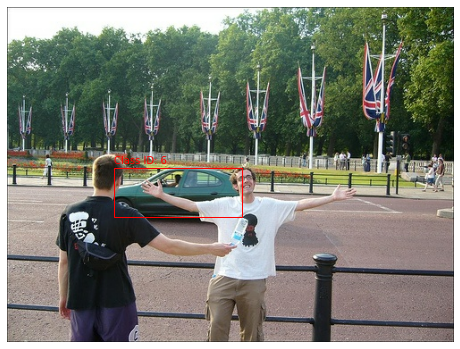

In [242]:
visualize(image, boxes, labels, target_class, tensorflow_format=True, annotate=True, annotation='Class ID: {}')

#### Step 3: Extracting Regions

We have already implemented a function for extracting the potential regions in an image, `selective_search()`. Let us see the extracted regions in our example images:

In [243]:
regions = selective_search(image)
len(regions)

2293

This process took 3 seconds and returned over 2000 regions! Obviously, we can't plot all of them on the image. Let's only draw the first `N` elements. We can use the `visualize` function without passing in any labels:

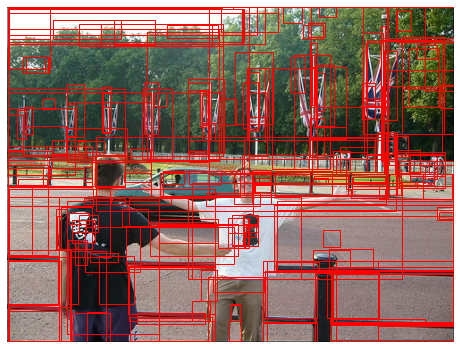

In [244]:
visualize(image, regions[:256])

#### Step 4: Classifying Regions

The only challenge in this part would be to transform the regions extracted from an image into a format `model.predict()` would accept. 

In [245]:
def extract_crops(image, regions, target_size):
    """
    Extracts the `regions` from the image and returns the resized versions.

    Parameters
    ----------
    image: ndarray
        Numpy array containing the BGR pixel values with the shape `(H, W, 3)`.
    regions: list
        Potential regions in the image, formatted as `xmin`, `ymin`, `xmax`, `ymax`.
    target_size: tuple
        Target height and width of the images, as a tuple of integers.
    Returns
    -------
    crops: list
        Cropped and resized regions.
    """

    ######################
    # Your code goes here.
    crops = []
    for xmin, ymin, xmax, ymax in regions:
      # crop
      image_crop = image[ymin:ymax,xmin:xmax]
      # resize
      region = cv2.resize(image_crop, target_size)
      crops.append(region)
    crops = np.array(crops)
    ######################
    return crops



If we apply this function to our image, we should get an array with the following shape:

In [246]:
crops = extract_crops(image, regions, target_size)
crops = np.array(crops)
crops.shape

(2293, 224, 224, 3)

and if we pass this array to the `predict` function, we'll get:

In [247]:
scores = model.predict(crops, batch_size)
scores = np.squeeze(scores)
scores.shape

36/36 [==============================] - 7s 168ms/step


(2293,)

We will only accept the regions that have a high score.

In [248]:
detections = [(region, score) for region, score in zip(regions, scores) if score > confidence_thresh]
len(detections)

28

Let's now once again visualize the extracted regions, but this time, we will draw the ones with the highest predicted scores:

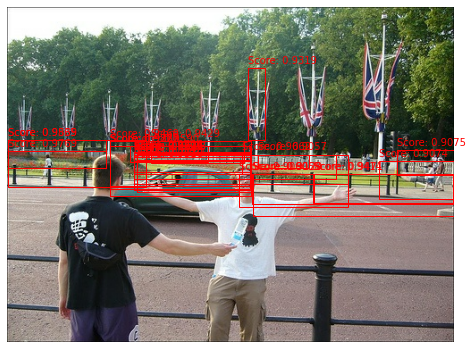

In [249]:
detection_boxes = [box for box, score in detections]
detection_scores = [score for box, score in detections]
visualize(image, detection_boxes, detection_scores, annotate=True, annotation='Score: {:.4f}')

That's pretty good! However, we can already see the importance of the next step. The 13 regions are duplicates and essentially, point to three objects. Therefore, we need to apply the NMS algorithm to get rid of them.

#### Step 5: Non-Maximum Suppresion

Let us define a function that would receive the boxes and their associated scores and returns the maximal boxes. We would need to define another IoU threshold, to specify which boxes are considered overlapping. Once again, we can tune this hyperparameter using the validation set. However, we are simply going to go with $0.2$.

In [250]:
def non_max_suppression(detections, threshold=0.2):
    """
    Applies the NMS algorithm to the `detections`.

    Parameters
    ----------
    detections: list
        The unfiltered detections, formatted as `xmin`, `ymin`, `xmax`, `ymax`.
    threshold: float
        The IoU threshold at which two boxes would be considered duplicates.

    Returns
    -------
    boxes: list
        Filtered detections, formatted as `xmin`, `ymin`, `xmax`, `ymax`.
    scores: list
        Confidence scores associated with the filtered detections.
    """

    bounding_boxes = [box for box, score in detections]
    confidence_score = [score for box, score in detections]

    picked_boxes = []
    picked_score = []

    for i in range(len(bounding_boxes)):
      for j in range(i+1, len(bounding_boxes)):
        if compute_iou(bounding_boxes[i],bounding_boxes[j]) < threshold:
          if (bounding_boxes[i] in picked_boxes) == 0:
            picked_boxes.append(bounding_boxes[i])
            picked_score.append(confidence_score[i])

        # compute_iou(bounding_boxes[i],bounding_boxes[j]) > threshold
        else :
          if confidence_score[i] > confidence_score[j]:
            if (bounding_boxes[i] in picked_boxes) == 0:
              picked_boxes.append(bounding_boxes[i])
              picked_score.append(confidence_score[i])
            
            #confidence_score[i] < confidence_score[j]
            else :
              # remove  bounding_boxes with a smaller score value 
              if (bounding_boxes[i] in picked_boxes) == 1:
                picked_boxes.remove(bounding_boxes[i])
                picked_score.remove(confidence_score[i])

              # append bounding_boxes with a larger score value 
              if (bounding_boxes[j] in picked_boxes) == 0:
                picked_boxes.append(bounding_boxes[j])
                picked_score.append(confidence_score[j])

    return picked_boxes, picked_score

If we apply this function to our sample image, our boxes will be reduced to:

In [251]:
detection_boxes, detection_scores = non_max_suppression(detections)
len(detection_boxes)

27

which when drawn, look like this:

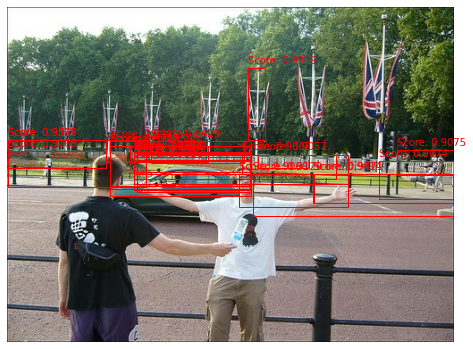

In [252]:
visualize(image, detection_boxes, detection_scores, annotate=True, annotation='Score: {:.4f}')

#### Step 6: Putting it Together

That's it! Let's put together a function that can perform these operations for a passed image.

In [253]:
def inference(sample, target_class):

    image = sample['image'].numpy()
    height, width, channels = image.shape
    objects = sample['objects']
    labels = objects['label'].numpy()
    boxes = objects['bbox'].numpy()

    # Since we excluded all boxes that didn't contain our target class during 
    # training, we have to exclude them during inference as well.
    boxes = [box for box, label in zip(boxes, labels) if label == target_class]

    boxes = [(int(xmin * width), int(ymin * height), int(xmax * width), int(ymax * height)) for ymin, xmin, ymax, xmax in boxes]

    regions = selective_search(image)
    crops = extract_crops(image, regions, target_size)
    scores = model.predict(crops, batch_size, verbose=0)
    scores = np.squeeze(scores)
    detections = [(region, score) for region, score in zip(regions, scores) if score > confidence_thresh]
    detection_boxes, detection_scores = non_max_suppression(detections)

    return boxes, detection_boxes 

Next, let us implement a function that takes in the sets of groundtruth boxes and the predicted boxes in an image, and returns the confusion matrix. We need a final IoU threshold, this time to specify a *Positive* prediction. We will set this hyperparameter to $0.5$.

In [254]:
def confusion_matrix(true_boxes, pred_boxes, match_thresh=0.5):
    TP, FP, FN = 0, 0, 0

    ######################
    # Your code goes here.
    for true_box in true_boxes:
      for pred_box in pred_boxes:
        if (compute_iou(true_box,pred_box) > match_thresh):
          TP += 1
          
    # pred_boxes = TP + FP
    FP = len(pred_boxes) - TP
    # true_boxes = TP + FN   
    FN = len(true_boxes) - TP
    ######################

    return TP, FP, FN

That's about it. We can now process the entire `test_set` and evaluate our model. We will only calculate the precision and the recall.

**Note**: This process is really slow. If we want to process the entirity of the `test_set`, it can take up to 12 hours. Instead, we will only use 100 samples.

In [255]:
total_TP, total_FP, total_FN = 0, 0, 0
for sample in tqdm(test_set.take(100)):
    true_boxes, pred_boxes = inference(sample, target_class)
    TP, FP, FN = confusion_matrix(true_boxes, pred_boxes)
    total_TP += TP
    total_FP += FP
    total_FN += FN
precision = total_TP / (total_TP + total_FP)
recall = total_TP / (total_TP + total_FN)

  0%|          | 0/100 [00:00<?, ?it/s]

In [256]:
print('TPs:', total_TP, 'FPs:', total_FP, 'FNs:', total_FN)
print(f'Precision: {precision:.4f} Recall: {recall:.4f}')

TPs: 2 FPs: 1214 FNs: 18
Precision: 0.0016 Recall: 0.1000


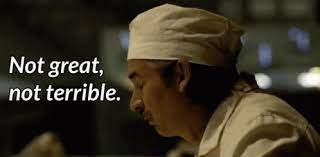



Regardless, make sure that your results aren't too far off. Otherwise, you might have made a mistake. Improving the performance of the model over these values will earn you bonus points.